In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def plot_accuracies(accuracies):
    """
    Expects a pandas datafame with colums containing column lengths and indices containing doc depths
    """
    fig, ax = plt.subplots(figsize=(15, 10))

    # colors copied from reference plot
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
    sns.heatmap(
        data.iloc[::-1],
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=100,
        #xticklabels=x_labels,
        #yticklabels=y_labels,
        linecolor='gray',
        linewidths=0.1
    )

    ax.set_title('Pressure Testing StreamingLLM + RAG', pad=20, size=16)
    ax.set_xlabel('Context Length (# tokens)', size=14)
    ax.set_ylabel('Document Depth', size=14)

    fig.tight_layout()
    return fig

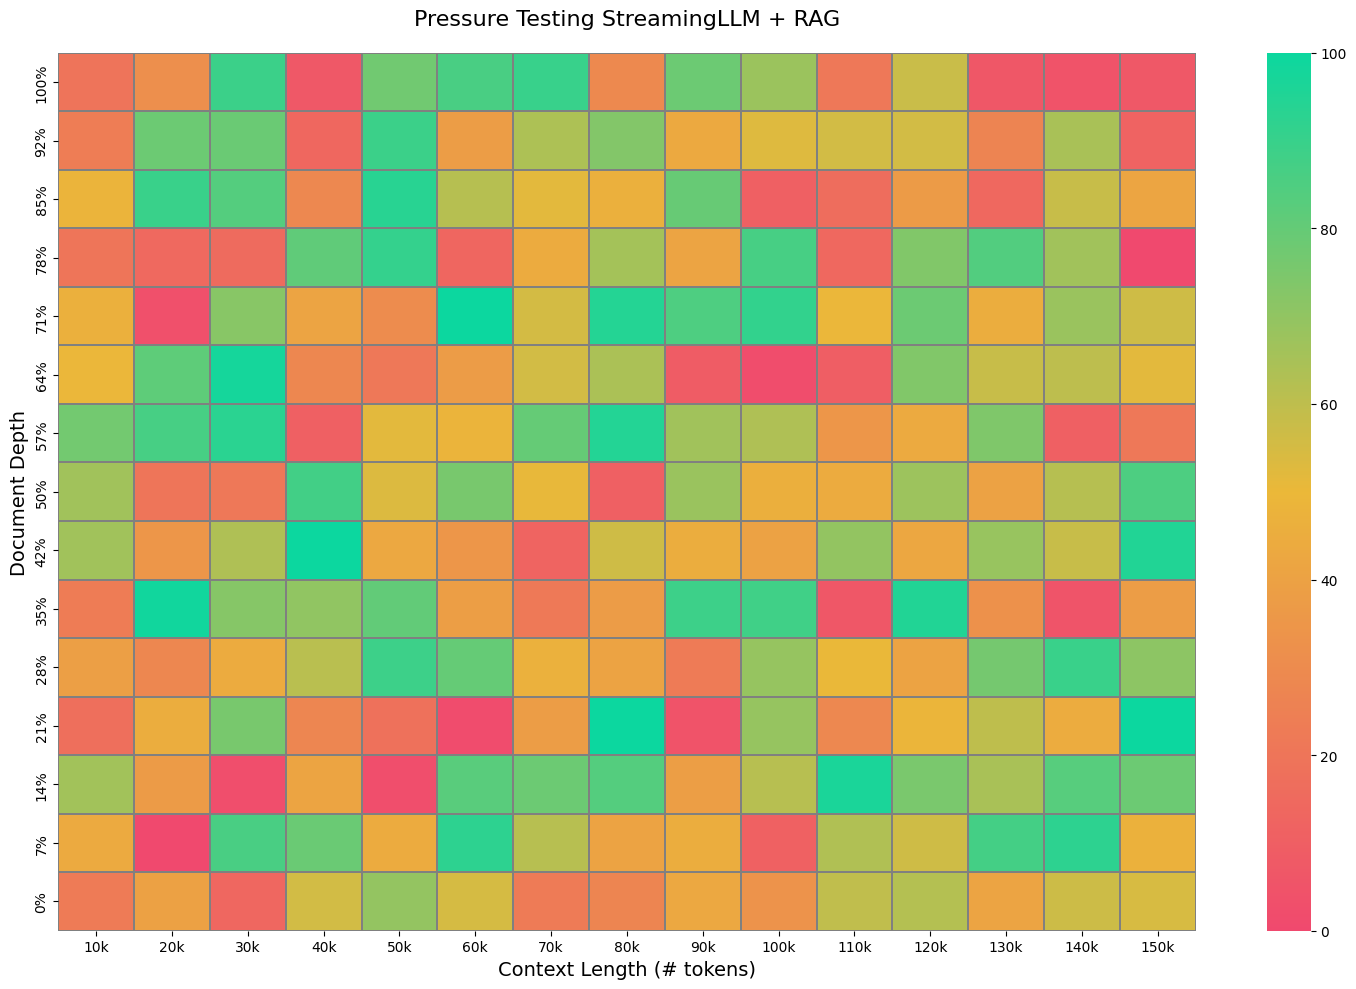

In [43]:
example_size = 15
doc_lengths = [10000 * i for i in range(1,example_size + 1)]
data = pd.DataFrame(
    data=np.random.uniform(0, 100, size=(example_size, example_size)),
    columns=[str(int(length / 1000)) + 'k' for length in doc_lengths],
    index=[str(int(100 * i / (example_size - 1))) + '%' for i in range(example_size)]
)

fig = plot_accuracies(data)
fig.savefig('accuracies.png', dpi=300, bbox_inches='tight')